## FLAGS (IMPORTANT)

In [1]:
VALIDATE_NN = False
TRAIN = True
VALIDATE_SVM = True

# change code to use these flags and do the action otherwise load necessary stuff already saved

## Constants

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
HIGH_COUNT = 100
LOW_FRAC = 1/64
ZERO_FRAC = 0.5
TEST_COUNT = 100

In [4]:
CENTRE = 4 * torch.ones(7)
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [5]:
LOW_RADIUS = 1.
HIGH_RADIUS = 2.

## Data

In [6]:
from scripts.data.orthants import generate_train_data

In [7]:
X_training, Y_training, orthant_counts = generate_train_data(
    low_count=HIGH_COUNT,
    high_count=HIGH_COUNT,
    low_spread=0,
    high_spread=0,
    low_frac=LOW_FRAC,
    zero_frac=ZERO_FRAC,
    random_state=7357
)
X_training.shape, Y_training.shape

(torch.Size([25400, 7]), torch.Size([25400, 1]))

In [8]:
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDEX = i
ZERO_ORTHANT_INDEX

80

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2, random_state=535)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([20320, 7]),
 torch.Size([5080, 7]),
 torch.Size([20320, 1]),
 torch.Size([5080, 1]))

In [10]:
from scripts.data.orthants import generate_test_data

X_test, Y_test = generate_test_data(TEST_COUNT, random_state=7753)
X_test.shape, Y_test.shape

(torch.Size([128, 200, 7]), torch.Size([128, 200, 1]))

In [11]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

In [12]:
X_total_0 = X_training[Y_training.squeeze()==0]
X_total_1 = X_training[Y_training.squeeze()==1]

In [13]:
from scripts.data.orthants import find_orthant

def obtain_closest_point_orthant(
    test_point: torch.Tensor,
    pos_points: torch.Tensor,
    neg_points: torch.Tensor
) -> torch.Tensor:
    pos_distances, neg_distances = torch.sqrt(torch.sum((test_point - pos_points)**2, dim=1)), torch.sqrt(torch.sum((test_point - neg_points)**2, dim=1))
    return torch.tensor([find_orthant(pos_points[torch.argmin(pos_distances)]), find_orthant(neg_points[torch.argmin(neg_distances)])])

In [14]:
import pandas as pd

closest_orthants_0 = pd.DataFrame(torch.cat([
    obtain_closest_point_orthant(x, X_total_0, X_total_1).reshape(1, -1) for x in X_test[ZERO_ORTHANT_INDEX][Y_test[ZERO_ORTHANT_INDEX].squeeze() == 0]
]), columns=['closest_positive_orthant', 'closest_negative_orthant'])
closest_orthants_1 = pd.DataFrame(torch.cat([
    obtain_closest_point_orthant(x, X_total_0, X_total_1).reshape(1, -1) for x in X_test[ZERO_ORTHANT_INDEX][Y_test[ZERO_ORTHANT_INDEX].squeeze() == 1]
]), columns=['closest_positive_orthant', 'closest_negative_orthant'])

In [15]:
closest_orthants_0['closest_positive_orthant'].value_counts(), closest_orthants_0['closest_negative_orthant'].value_counts() 

(16     43
 112    27
 64     16
 88     11
 81      2
 84      1
 Name: closest_positive_orthant, dtype: int64,
 16     47
 112    28
 64     23
 88      2
 Name: closest_negative_orthant, dtype: int64)

In [16]:
closest_orthants_1['closest_positive_orthant'].value_counts(), closest_orthants_1['closest_negative_orthant'].value_counts() 

(112    31
 16     31
 64     21
 88     14
 84      3
 Name: closest_positive_orthant, dtype: int64,
 16     33
 112    32
 64     22
 88     12
 84      1
 Name: closest_negative_orthant, dtype: int64)

## Neural network

In [17]:
device = 'cpu'

In [18]:
from scripts.models import SimpleNN
from scripts.train import train_model
from scripts.metrics import BinaryAccuracy

In [19]:
depths = [1, 2, 3, 4, 5]
widths = [32, 64, 128]
etas = [1e-4, 1e-3, 1e-2]
weight_decays = np.logspace(-5, 5, 11).tolist() 
weight_decays.append(0.0)

In [20]:
import json

if VALIDATE_NN:
    best_depth = None
    best_width = None
    best_eta = None
    best_weight_decay = None
    best_score = -torch.inf
else:
    with open('configs/nn/orthants-single-empty.json', 'r') as f:
        best_config = json.load(f)
    best_depth = best_config['depth']
    best_width = best_config['width']
    best_eta = best_config['eta']
    best_weight_decay = best_config['weight_decay']
    best_score = best_config['score']

In [21]:
import json

total_count = len(depths) * len(widths) * len(etas) * len(weight_decays)
curr_count = 0
EPOCHS = 10

if VALIDATE_NN:
    print(f'Cross-validating across {total_count} models.\n')

    for depth in depths:
        for width in widths:
            for eta in etas:
                for weight_decay in weight_decays:
                    model = SimpleNN(7, hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=weight_decay)
                    metric = BinaryAccuracy()

                    history = train_model(
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    curr_count += 1
                    score = history['val_score'][-1]
                    print(f'[{curr_count}/{total_count}] Depth: {depth}, width: {width}, lr: {eta}, lambda: {weight_decay} ==> score: {score:.6f}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_eta = eta
                        best_weight_decay = weight_decay
    best_config = {
        'score': float(best_score),
        'depth': best_depth,
        'width': best_width,
        'eta': best_eta,
        'weight_decay': best_weight_decay
    }
    with open('configs/nn/orthants-single-empty.json', 'w') as f:
        json.dump(best_config, f)

print(f'\nBest validation score after {EPOCHS} epochs: {best_score:.6f}')
print(f'Best configuration: depth: {best_depth}, width: {best_width}, lr: {best_eta}, lambda: {best_weight_decay}')


Best validation score after 10 epochs: 0.913194
Best configuration: depth: 3, width: 32, lr: 0.001, lambda: 0.0


In [22]:
best_model_nn = SimpleNN(7, hidden_layers=best_depth, hidden_units=best_width).to(device)

In [23]:
from scripts.utils import EarlyStopping

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = BinaryAccuracy()
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [24]:
if TRAIN:
    history = train_model(
        model=best_model_nn,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric=metric,
        epochs=500,
        early_stopping=early_stop,
        device=device,
        return_models=True
    )
    torch.save(best_model_nn.state_dict(), 'models/orthants-single-empty.pth')
else:
    best_model_nn.load_state_dict(torch.load('models/orthants-single-empty.pth'))

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.693578, Train score: 0.501427, Val loss: 0.693330, Val score: 0.500590
Epoch: 2 => Train loss: 0.681571, Train score: 0.540797, Val loss: 0.622075, Val score: 0.670532
Epoch: 3 => Train loss: 0.535008, Train score: 0.725148, Val loss: 0.478971, Val score: 0.753472
Epoch: 4 => Train loss: 0.462305, Train score: 0.776476, Val loss: 0.450873, Val score: 0.784722
Epoch: 5 => Train loss: 0.446483, Train score: 0.786368, Val loss: 0.432159, Val score: 0.797694
Epoch: 6 => Train loss: 0.437454, Train score: 0.791142, Val loss: 0.444064, Val score: 0.785574
Epoch: 7 => Train loss: 0.437867, Train score: 0.790453, Val loss: 0.434202, Val score: 0.789439
Epoch: 8 => Train loss: 0.429782, Train score: 0.795030, Val loss: 0.431354, Val score: 0.793370
Epoch: 9 => Train loss: 0.425608, Train score: 0.798228, Val loss: 0.452398, Val score: 0.782757
Epoch: 10 => Train loss: 0.426947, Train score: 0.797884, Val loss: 0.43

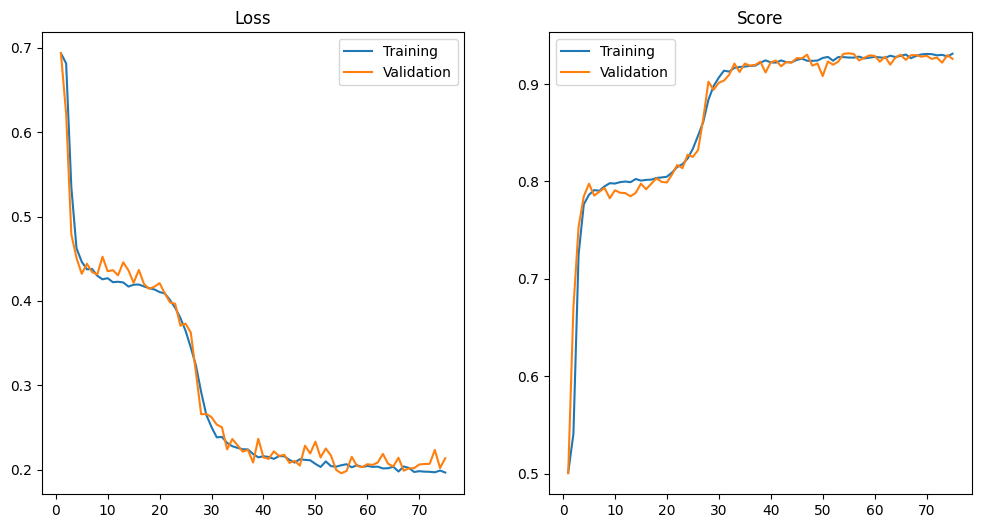

In [25]:
from scripts.utils import plot_train_history

if TRAIN:
    plot_train_history(history)

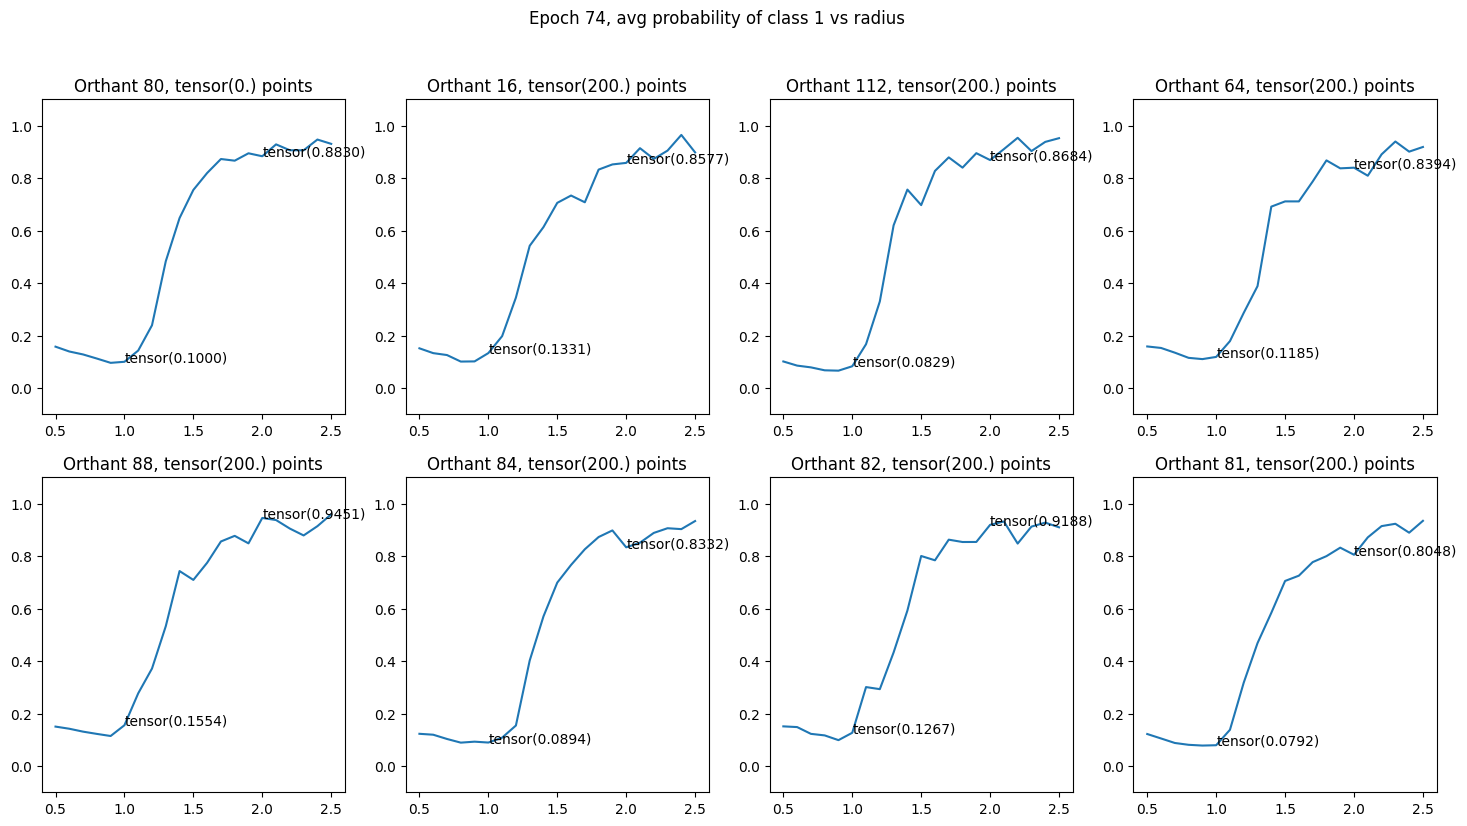

In [26]:
from scripts.utils import plot_radial_visualization

if TRAIN:
    plot_radial_visualization(
        models=history['models'],
        mp4_save_file_name='radial_1empty',
        orthant_counts=orthant_counts,
        main_orthant=ZERO_ORTHANT_INDEX,
        fps=4
    )

In [27]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

In [28]:
scores_nn.mean(), scores_nn[ZERO_ORTHANT_INDEX].mean()

(tensor(0.9256), tensor(0.9200))

## SVM

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [30]:
ntk = NTK(best_model_nn).get_ntk

In [31]:
model_base_ntk = SVC(kernel=ntk, max_iter=int(1e4))
params_ntk = {
    'C': np.logspace(-5, 5, 11)
}

gammas = np.logspace(-5, 5, 11).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVC(kernel='rbf', max_iter=int(1e4))
params_rbf = {
    'C': np.logspace(-5, 5, 11),
    'gamma': gammas
}

scorer = make_scorer(accuracy_score)

In [32]:
if VALIDATE_SVM:
    model_cv_ntk = GridSearchCV(
        estimator=model_base_ntk,
        param_grid=params_ntk,
        scoring=scorer,
        n_jobs=5,
        refit=False,
        verbose=3
    )
    model_cv_ntk.fit(X_train, Y_train.squeeze())
    best_params_ntk = model_cv_ntk.best_params_
    best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
    best_params_ntk, best_score_ntk

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 5/5] END ...........................C=1e-05;, score=0.523 total time= 1.7min
[CV 3/5] END ...........................C=1e-05;, score=0.537 total time= 1.7min
[CV 1/5] END ...........................C=1e-05;, score=0.528 total time= 1.7min
[CV 4/5] END ...........................C=1e-05;, score=0.527 total time= 1.7min
[CV 2/5] END ...........................C=1e-05;, score=0.529 total time= 1.7min
[CV 1/5] END ..........................C=0.0001;, score=0.573 total time=  58.6s
[CV 5/5] END ..........................C=0.0001;, score=0.541 total time=  58.3s
[CV 2/5] END ..........................C=0.0001;, score=0.563 total time= 1.0min
[CV 3/5] END ..........................C=0.0001;, score=0.592 total time= 1.0min
[CV 4/5] END ..........................C=0.0001;, score=0.562 total time= 1.0min
[CV 1/5] END ...........................C=0.001;, score=0.699 total time= 1.5min
[CV 3/5] END ...........................C=0.001;

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 1/5] END ............................C=0.01;, score=0.875 total time=  56.8s
[CV 2/5] END ............................C=0.01;, score=0.868 total time=  53.2s
[CV 3/5] END ............................C=0.01;, score=0.863 total time=  57.6s
[CV 5/5] END ............................C=0.01;, score=0.874 total time=  54.5s
[CV 4/5] END ............................C=0.01;, score=0.873 total time=  56.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............................C=0.1;, score=0.906 total time= 1.5min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .............................C=0.1;, score=0.898 total time= 1.6min
[CV 3/5] END .............................C=0.1;, score=0.892 total time= 1.6min
[CV 4/5] END .............................C=0.1;, score=0.905 total time= 1.6min
[CV 5/5] END .............................C=0.1;, score=0.909 total time= 1.7min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............................C=1.0;, score=0.580 total time=  46.4s
[CV 2/5] END .............................C=1.0;, score=0.564 total time=  47.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............................C=1.0;, score=0.567 total time= 1.0min
[CV 5/5] END .............................C=1.0;, score=0.564 total time= 1.2min
[CV 4/5] END .............................C=1.0;, score=0.667 total time= 1.3min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............................C=10.0;, score=0.530 total time= 1.5min
[CV 2/5] END ............................C=10.0;, score=0.527 total time= 1.6min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............................C=10.0;, score=0.537 total time= 1.5min
[CV 4/5] END ............................C=10.0;, score=0.535 total time= 1.3min
[CV 5/5] END ............................C=10.0;, score=0.532 total time= 1.2min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........................C=100.0;, score=0.528 total time=  50.3s
[CV 2/5] END ...........................C=100.0;, score=0.527 total time=  46.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ...........................C=100.0;, score=0.537 total time= 1.5min
[CV 3/5] END ...........................C=100.0;, score=0.540 total time= 1.6min
[CV 5/5] END ...........................C=100.0;, score=0.522 total time= 1.5min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..........................C=1000.0;, score=0.535 total time= 1.4min
[CV 2/5] END ..........................C=1000.0;, score=0.536 total time= 1.5min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 3/5] END ..........................C=1000.0;, score=0.543 total time=  59.9s
[CV 4/5] END ..........................C=1000.0;, score=0.594 total time=  59.3s
[CV 5/5] END ..........................C=1000.0;, score=0.539 total time=  58.1s
[CV 1/5] END .........................C=10000.0;, score=0.535 total time=  49.2s
[CV 2/5] END .........................C=10000.0;, score=0.536 total time=  48.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 4/5] END .........................C=10000.0;, score=0.594 total time= 1.5min
[CV 1/5] END ........................C=100000.0;, score=0.535 total time= 1.5min
[CV 3/5] END .........................C=10000.0;, score=0.543 total time= 1.6min
[CV 5/5] END .........................C=10000.0;, score=0.539 total time= 1.6min
[CV 2/5] END ........................C=100000.0;, score=0.536 total time= 1.5min


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ........................C=100000.0;, score=0.543 total time=  39.6s
[CV 4/5] END ........................C=100000.0;, score=0.594 total time=  38.8s
[CV 5/5] END ........................C=100000.0;, score=0.539 total time=  37.5s


In [33]:
if VALIDATE_SVM:
    model_cv_rbf = GridSearchCV(
        estimator=model_base_rbf,
        param_grid=params_rbf,
        scoring=scorer,
        n_jobs=5,
        refit=False,
        verbose=3
    )
    model_cv_rbf.fit(X_train, Y_train.squeeze())
    best_params_rbf = model_cv_rbf.best_params_
    best_score_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])
    best_params_rbf, best_score_rbf

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 4/5] END ..............C=1e-05, gamma=1e-05;, score=0.500 total time=  10.6s
[CV 1/5] END ..............C=1e-05, gamma=1e-05;, score=0.500 total time=  10.6s
[CV 3/5] END ..............C=1e-05, gamma=1e-05;, score=0.500 total time=  10.7s
[CV 2/5] END ..............C=1e-05, gamma=1e-05;, score=0.500 total time=  10.7s
[CV 5/5] END ..............C=1e-05, gamma=1e-05;, score=0.500 total time=  10.7s
[CV 4/5] END .............C=1e-05, gamma=0.0001;, score=0.500 total time=  11.2s
[CV 3/5] END .............C=1e-05, gamma=0.0001;, score=0.500 total time=  11.2s
[CV 2/5] END .............C=1e-05, gamma=0.0001;, score=0.500 total time=  11.3s
[CV 1/5] END .............C=1e-05, gamma=0.0001;, score=0.500 total time=  11.4s
[CV 5/5] END .............C=1e-05, gamma=0.0001;, score=0.500 total time=  11.4s
[CV 2/5] END ..............C=1e-05, gamma=0.001;, score=0.500 total time=  44.6s
[CV 3/5] END ..............C=1e-05, gamma=0.00

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .................C=1.0, gamma=0.01;, score=0.562 total time=  34.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .................C=1.0, gamma=0.01;, score=0.580 total time=  33.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .................C=1.0, gamma=0.01;, score=0.572 total time=  28.4s
[CV 4/5] END .................C=1.0, gamma=0.01;, score=0.590 total time=  25.9s
[CV 5/5] END .................C=1.0, gamma=0.01;, score=0.565 total time=  23.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..................C=1.0, gamma=0.1;, score=1.000 total time=  11.2s
[CV 2/5] END ..................C=1.0, gamma=0.1;, score=1.000 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..................C=1.0, gamma=0.1;, score=1.000 total time=  10.8s
[CV 4/5] END ..................C=1.0, gamma=0.1;, score=1.000 total time=  10.6s
[CV 5/5] END ..................C=1.0, gamma=0.1;, score=1.000 total time=  10.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..................C=1.0, gamma=1.0;, score=1.000 total time=  11.7s
[CV 2/5] END ..................C=1.0, gamma=1.0;, score=1.000 total time=  11.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..................C=1.0, gamma=1.0;, score=1.000 total time=  11.4s
[CV 4/5] END ..................C=1.0, gamma=1.0;, score=1.000 total time=  11.3s
[CV 5/5] END ..................C=1.0, gamma=1.0;, score=1.000 total time=  11.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .................C=1.0, gamma=10.0;, score=0.833 total time=  13.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .................C=1.0, gamma=10.0;, score=0.828 total time=  13.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .................C=1.0, gamma=10.0;, score=0.845 total time=  13.0s
[CV 4/5] END .................C=1.0, gamma=10.0;, score=0.829 total time=  13.0s
[CV 5/5] END .................C=1.0, gamma=10.0;, score=0.838 total time=  13.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=1.0, gamma=100.0;, score=0.613 total time=  11.9s
[CV 2/5] END ................C=1.0, gamma=100.0;, score=0.615 total time=  11.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=1.0, gamma=100.0;, score=0.614 total time=  11.6s
[CV 4/5] END ................C=1.0, gamma=100.0;, score=0.609 total time=  11.5s
[CV 5/5] END ................C=1.0, gamma=100.0;, score=0.609 total time=  11.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...............C=1.0, gamma=1000.0;, score=0.526 total time=  10.8s
[CV 1/5] END ...............C=1.0, gamma=1000.0;, score=0.525 total time=  10.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=1.0, gamma=1000.0;, score=0.523 total time=  10.7s
[CV 4/5] END ...............C=1.0, gamma=1000.0;, score=0.521 total time=  10.6s
[CV 5/5] END ...............C=1.0, gamma=1000.0;, score=0.522 total time=  10.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..............C=1.0, gamma=10000.0;, score=0.502 total time=  10.0s
[CV 1/5] END ..............C=1.0, gamma=10000.0;, score=0.504 total time=  10.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=1.0, gamma=10000.0;, score=0.506 total time=  10.4s
[CV 4/5] END ..............C=1.0, gamma=10000.0;, score=0.505 total time=  10.4s
[CV 5/5] END ..............C=1.0, gamma=10000.0;, score=0.501 total time=  10.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=1.0, gamma=100000.0;, score=0.500 total time=  12.2s
[CV 2/5] END .............C=1.0, gamma=100000.0;, score=0.500 total time=  13.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=1.0, gamma=100000.0;, score=0.500 total time=  20.1s
[CV 4/5] END .............C=1.0, gamma=100000.0;, score=0.500 total time=  20.8s
[CV 5/5] END .............C=1.0, gamma=100000.0;, score=0.500 total time=  25.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=1.0, gamma=scale;, score=0.565 total time=  48.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ................C=1.0, gamma=scale;, score=0.587 total time=  47.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=1.0, gamma=scale;, score=0.574 total time=  42.2s
[CV 4/5] END ................C=1.0, gamma=scale;, score=0.585 total time=  41.3s
[CV 5/5] END ................C=1.0, gamma=scale;, score=0.578 total time=  37.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .................C=1.0, gamma=auto;, score=1.000 total time=  11.2s
[CV 2/5] END .................C=1.0, gamma=auto;, score=1.000 total time=  10.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .................C=1.0, gamma=auto;, score=1.000 total time=  10.4s
[CV 4/5] END .................C=1.0, gamma=auto;, score=1.000 total time=  10.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END .................C=1.0, gamma=auto;, score=1.000 total time=  10.2s
[CV 1/5] END ...............C=10.0, gamma=1e-05;, score=0.493 total time=  14.0s
[CV 2/5] END ...............C=10.0, gamma=1e-05;, score=0.487 total time=  14.0s
[CV 4/5] END ...............C=10.0, gamma=1e-05;, score=0.498 total time=  13.4s
[CV 3/5] END ...............C=10.0, gamma=1e-05;, score=0.497 total time=  13.7s
[CV 5/5] END ...............C=10.0, gamma=1e-05;, score=0.504 total time=  13.4s
[CV 1/5] END ..............C=10.0, gamma=0.0001;, score=0.492 total time=  12.5s
[CV 2/5] END ..............C=10.0, gamma=0.0001;, score=0.491 total time=  12.2s
[CV 3/5] END ..............C=10.0, gamma=0.0001;, score=0.476 total time=  12.1s
[CV 4/5] END ..............C=10.0, gamma=0.0001;, score=0.473 total time=  12.1s
[CV 5/5] END ..............C=10.0, gamma=0.0001;, score=0.490 total time=  12.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=10.0, gamma=0.001;, score=0.564 total time=  11.3s
[CV 2/5] END ...............C=10.0, gamma=0.001;, score=0.592 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=10.0, gamma=0.001;, score=0.576 total time=  11.2s
[CV 4/5] END ...............C=10.0, gamma=0.001;, score=0.570 total time=  11.2s
[CV 5/5] END ...............C=10.0, gamma=0.001;, score=0.572 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=10.0, gamma=0.01;, score=0.834 total time=  10.5s
[CV 2/5] END ................C=10.0, gamma=0.01;, score=0.833 total time=  10.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=10.0, gamma=0.01;, score=0.848 total time=  10.5s
[CV 4/5] END ................C=10.0, gamma=0.01;, score=0.852 total time=  10.4s
[CV 5/5] END ................C=10.0, gamma=0.01;, score=0.828 total time=  10.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .................C=10.0, gamma=0.1;, score=1.000 total time=   5.0s
[CV 1/5] END .................C=10.0, gamma=0.1;, score=1.000 total time=   5.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .................C=10.0, gamma=0.1;, score=1.000 total time=   5.0s
[CV 3/5] END .................C=10.0, gamma=0.1;, score=1.000 total time=   5.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END .................C=10.0, gamma=0.1;, score=1.000 total time=   5.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .................C=10.0, gamma=1.0;, score=1.000 total time=   9.1s
[CV 2/5] END .................C=10.0, gamma=1.0;, score=1.000 total time=   9.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .................C=10.0, gamma=1.0;, score=1.000 total time=   9.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .................C=10.0, gamma=1.0;, score=1.000 total time=   9.5s
[CV 5/5] END .................C=10.0, gamma=1.0;, score=1.000 total time=   9.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=10.0, gamma=10.0;, score=0.838 total time=  21.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ................C=10.0, gamma=10.0;, score=0.834 total time=  22.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=10.0, gamma=10.0;, score=0.852 total time=  31.3s
[CV 4/5] END ................C=10.0, gamma=10.0;, score=0.833 total time=  33.0s
[CV 5/5] END ................C=10.0, gamma=10.0;, score=0.843 total time=  37.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=10.0, gamma=100.0;, score=0.620 total time=  43.0s
[CV 2/5] END ...............C=10.0, gamma=100.0;, score=0.623 total time=  42.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=10.0, gamma=100.0;, score=0.621 total time=  35.1s
[CV 4/5] END ...............C=10.0, gamma=100.0;, score=0.616 total time=  33.6s
[CV 5/5] END ...............C=10.0, gamma=100.0;, score=0.616 total time=  29.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..............C=10.0, gamma=1000.0;, score=0.532 total time=  15.3s
[CV 1/5] END ..............C=10.0, gamma=1000.0;, score=0.531 total time=  15.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=10.0, gamma=1000.0;, score=0.529 total time=  14.9s
[CV 4/5] END ..............C=10.0, gamma=1000.0;, score=0.525 total time=  14.7s
[CV 5/5] END ..............C=10.0, gamma=1000.0;, score=0.527 total time=  14.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .............C=10.0, gamma=10000.0;, score=0.502 total time=  12.5s
[CV 1/5] END .............C=10.0, gamma=10000.0;, score=0.505 total time=  13.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=10.0, gamma=10000.0;, score=0.507 total time=  12.6s
[CV 4/5] END .............C=10.0, gamma=10000.0;, score=0.506 total time=  12.4s
[CV 5/5] END .............C=10.0, gamma=10000.0;, score=0.501 total time=  12.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=10.0, gamma=100000.0;, score=0.500 total time=  11.4s
[CV 2/5] END ............C=10.0, gamma=100000.0;, score=0.500 total time=  11.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=10.0, gamma=100000.0;, score=0.500 total time=  11.0s
[CV 4/5] END ............C=10.0, gamma=100000.0;, score=0.500 total time=  11.1s
[CV 5/5] END ............C=10.0, gamma=100000.0;, score=0.500 total time=  11.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=10.0, gamma=scale;, score=0.751 total time=  10.5s
[CV 2/5] END ...............C=10.0, gamma=scale;, score=0.769 total time=  10.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=10.0, gamma=scale;, score=0.762 total time=  10.4s
[CV 4/5] END ...............C=10.0, gamma=scale;, score=0.757 total time=  10.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ...............C=10.0, gamma=scale;, score=0.766 total time=  10.4s
[CV 1/5] END ................C=10.0, gamma=auto;, score=1.000 total time=   5.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ................C=10.0, gamma=auto;, score=1.000 total time=   5.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=10.0, gamma=auto;, score=1.000 total time=   5.3s
[CV 4/5] END ................C=10.0, gamma=auto;, score=1.000 total time=   5.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ................C=10.0, gamma=auto;, score=1.000 total time=   5.2s
[CV 1/5] END ..............C=100.0, gamma=1e-05;, score=0.493 total time=  10.3s
[CV 2/5] END ..............C=100.0, gamma=1e-05;, score=0.491 total time=  10.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=100.0, gamma=1e-05;, score=0.475 total time=  10.7s
[CV 4/5] END ..............C=100.0, gamma=1e-05;, score=0.465 total time=  10.9s
[CV 5/5] END ..............C=100.0, gamma=1e-05;, score=0.484 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=100.0, gamma=0.0001;, score=0.568 total time=  11.9s
[CV 2/5] END .............C=100.0, gamma=0.0001;, score=0.594 total time=  12.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=100.0, gamma=0.0001;, score=0.596 total time=  12.0s
[CV 3/5] END .............C=100.0, gamma=0.0001;, score=0.568 total time=  12.3s
[CV 5/5] END .............C=100.0, gamma=0.0001;, score=0.580 total time=  12.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=100.0, gamma=0.001;, score=0.572 total time=  28.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..............C=100.0, gamma=0.001;, score=0.594 total time=  35.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=100.0, gamma=0.001;, score=0.584 total time=  42.6s
[CV 4/5] END ..............C=100.0, gamma=0.001;, score=0.541 total time=  43.6s
[CV 5/5] END ..............C=100.0, gamma=0.001;, score=0.574 total time=  46.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=100.0, gamma=0.01;, score=0.902 total time=  26.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...............C=100.0, gamma=0.01;, score=0.908 total time=  20.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=100.0, gamma=0.01;, score=0.900 total time=  13.8s
[CV 4/5] END ...............C=100.0, gamma=0.01;, score=0.863 total time=  13.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=100.0, gamma=0.1;, score=1.000 total time=   7.6s
[CV 5/5] END ...............C=100.0, gamma=0.01;, score=0.854 total time=  10.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ................C=100.0, gamma=0.1;, score=1.000 total time=   7.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=100.0, gamma=0.1;, score=1.000 total time=   7.4s
[CV 4/5] END ................C=100.0, gamma=0.1;, score=1.000 total time=   7.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ................C=100.0, gamma=0.1;, score=1.000 total time=   7.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=100.0, gamma=1.0;, score=1.000 total time=  13.2s
[CV 2/5] END ................C=100.0, gamma=1.0;, score=1.000 total time=  12.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ................C=100.0, gamma=1.0;, score=1.000 total time=  12.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ................C=100.0, gamma=1.0;, score=1.000 total time=  13.0s
[CV 5/5] END ................C=100.0, gamma=1.0;, score=1.000 total time=  12.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=100.0, gamma=10.0;, score=0.838 total time=  15.5s
[CV 2/5] END ...............C=100.0, gamma=10.0;, score=0.834 total time=  14.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=100.0, gamma=10.0;, score=0.852 total time=  14.6s
[CV 4/5] END ...............C=100.0, gamma=10.0;, score=0.833 total time=  14.2s
[CV 5/5] END ...............C=100.0, gamma=10.0;, score=0.843 total time=  14.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=100.0, gamma=100.0;, score=0.620 total time=  12.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..............C=100.0, gamma=100.0;, score=0.623 total time=  12.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=100.0, gamma=100.0;, score=0.621 total time=  12.0s
[CV 4/5] END ..............C=100.0, gamma=100.0;, score=0.616 total time=  11.9s
[CV 5/5] END ..............C=100.0, gamma=100.0;, score=0.616 total time=  11.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=100.0, gamma=1000.0;, score=0.531 total time=  11.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .............C=100.0, gamma=1000.0;, score=0.532 total time=  10.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=100.0, gamma=1000.0;, score=0.529 total time=  11.1s
[CV 4/5] END .............C=100.0, gamma=1000.0;, score=0.525 total time=  11.3s
[CV 5/5] END .............C=100.0, gamma=1000.0;, score=0.527 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ............C=100.0, gamma=10000.0;, score=0.502 total time=  10.5s
[CV 1/5] END ............C=100.0, gamma=10000.0;, score=0.505 total time=  11.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=100.0, gamma=10000.0;, score=0.507 total time=  10.9s
[CV 4/5] END ............C=100.0, gamma=10000.0;, score=0.506 total time=  11.0s
[CV 5/5] END ............C=100.0, gamma=10000.0;, score=0.501 total time=  10.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=100.0, gamma=100000.0;, score=0.500 total time=  11.1s
[CV 2/5] END ...........C=100.0, gamma=100000.0;, score=0.500 total time=  11.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=100.0, gamma=100000.0;, score=0.500 total time=  11.6s
[CV 4/5] END ...........C=100.0, gamma=100000.0;, score=0.500 total time=  12.5s
[CV 5/5] END ...........C=100.0, gamma=100000.0;, score=0.500 total time=  12.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=100.0, gamma=scale;, score=0.807 total time=  18.3s
[CV 2/5] END ..............C=100.0, gamma=scale;, score=0.860 total time=  18.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=100.0, gamma=scale;, score=0.837 total time=  30.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ..............C=100.0, gamma=scale;, score=0.846 total time=  33.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ..............C=100.0, gamma=scale;, score=0.872 total time=  36.6s
[CV 2/5] END ...............C=100.0, gamma=auto;, score=1.000 total time=  27.7s
[CV 1/5] END ...............C=100.0, gamma=auto;, score=1.000 total time=  28.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=100.0, gamma=auto;, score=1.000 total time=  22.4s
[CV 4/5] END ...............C=100.0, gamma=auto;, score=1.000 total time=  18.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ...............C=100.0, gamma=auto;, score=1.000 total time=  16.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=1000.0, gamma=1e-05;, score=0.493 total time=  21.6s
[CV 2/5] END .............C=1000.0, gamma=1e-05;, score=0.491 total time=  21.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=1000.0, gamma=1e-05;, score=0.486 total time=  15.9s
[CV 4/5] END .............C=1000.0, gamma=1e-05;, score=0.471 total time=  15.8s
[CV 5/5] END .............C=1000.0, gamma=1e-05;, score=0.460 total time=  15.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=1000.0, gamma=0.0001;, score=0.542 total time=  13.8s
[CV 2/5] END ............C=1000.0, gamma=0.0001;, score=0.556 total time=  13.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=1000.0, gamma=0.0001;, score=0.583 total time=  12.8s
[CV 4/5] END ............C=1000.0, gamma=0.0001;, score=0.572 total time=  12.7s
[CV 5/5] END ............C=1000.0, gamma=0.0001;, score=0.585 total time=  12.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=1000.0, gamma=0.001;, score=0.502 total time=  10.1s
[CV 2/5] END .............C=1000.0, gamma=0.001;, score=0.497 total time=  10.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=1000.0, gamma=0.001;, score=0.498 total time=   9.7s
[CV 4/5] END .............C=1000.0, gamma=0.001;, score=0.483 total time=   9.8s
[CV 5/5] END .............C=1000.0, gamma=0.001;, score=0.497 total time=   9.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=1000.0, gamma=0.01;, score=0.877 total time=   6.7s
[CV 2/5] END ..............C=1000.0, gamma=0.01;, score=0.799 total time=   6.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=1000.0, gamma=0.01;, score=0.883 total time=   6.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ..............C=1000.0, gamma=0.01;, score=0.850 total time=   7.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ..............C=1000.0, gamma=0.01;, score=0.807 total time=   7.0s
[CV 1/5] END ...............C=1000.0, gamma=0.1;, score=1.000 total time=   5.9s
[CV 2/5] END ...............C=1000.0, gamma=0.1;, score=1.000 total time=   5.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=1000.0, gamma=0.1;, score=1.000 total time=   5.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ...............C=1000.0, gamma=0.1;, score=1.000 total time=   5.4s
[CV 5/5] END ...............C=1000.0, gamma=0.1;, score=1.000 total time=   5.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...............C=1000.0, gamma=1.0;, score=1.000 total time=   9.4s
[CV 1/5] END ...............C=1000.0, gamma=1.0;, score=1.000 total time=   9.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=1000.0, gamma=1.0;, score=1.000 total time=   9.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ...............C=1000.0, gamma=1.0;, score=1.000 total time=   9.3s
[CV 5/5] END ...............C=1000.0, gamma=1.0;, score=1.000 total time=   9.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=1000.0, gamma=10.0;, score=0.838 total time=  12.2s
[CV 2/5] END ..............C=1000.0, gamma=10.0;, score=0.834 total time=  12.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=1000.0, gamma=10.0;, score=0.852 total time=  12.4s
[CV 4/5] END ..............C=1000.0, gamma=10.0;, score=0.833 total time=  12.2s
[CV 5/5] END ..............C=1000.0, gamma=10.0;, score=0.843 total time=  12.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=1000.0, gamma=100.0;, score=0.620 total time=  11.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .............C=1000.0, gamma=100.0;, score=0.623 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=1000.0, gamma=100.0;, score=0.621 total time=  11.3s
[CV 4/5] END .............C=1000.0, gamma=100.0;, score=0.616 total time=  11.7s
[CV 5/5] END .............C=1000.0, gamma=100.0;, score=0.616 total time=  11.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=1000.0, gamma=1000.0;, score=0.531 total time=  27.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ............C=1000.0, gamma=1000.0;, score=0.532 total time=  28.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=1000.0, gamma=1000.0;, score=0.529 total time=  37.9s
[CV 4/5] END ............C=1000.0, gamma=1000.0;, score=0.525 total time=  43.0s
[CV 5/5] END ............C=1000.0, gamma=1000.0;, score=0.527 total time=  44.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...........C=1000.0, gamma=10000.0;, score=0.502 total time=  35.9s
[CV 1/5] END ...........C=1000.0, gamma=10000.0;, score=0.505 total time=  37.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=1000.0, gamma=10000.0;, score=0.507 total time=  28.0s
[CV 4/5] END ...........C=1000.0, gamma=10000.0;, score=0.506 total time=  23.1s
[CV 5/5] END ...........C=1000.0, gamma=10000.0;, score=0.501 total time=  21.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..........C=1000.0, gamma=100000.0;, score=0.500 total time=  13.9s
[CV 2/5] END ..........C=1000.0, gamma=100000.0;, score=0.500 total time=  13.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..........C=1000.0, gamma=100000.0;, score=0.500 total time=  13.3s
[CV 4/5] END ..........C=1000.0, gamma=100000.0;, score=0.500 total time=  13.5s
[CV 5/5] END ..........C=1000.0, gamma=100000.0;, score=0.500 total time=  13.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=1000.0, gamma=scale;, score=0.807 total time=   8.8s
[CV 2/5] END .............C=1000.0, gamma=scale;, score=0.775 total time=   8.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=1000.0, gamma=scale;, score=0.780 total time=   8.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=1000.0, gamma=scale;, score=0.785 total time=   8.5s
[CV 5/5] END .............C=1000.0, gamma=scale;, score=0.742 total time=   8.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=1000.0, gamma=auto;, score=1.000 total time=   6.7s
[CV 2/5] END ..............C=1000.0, gamma=auto;, score=1.000 total time=   6.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=1000.0, gamma=auto;, score=1.000 total time=   6.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ..............C=1000.0, gamma=auto;, score=1.000 total time=   6.2s
[CV 5/5] END ..............C=1000.0, gamma=auto;, score=1.000 total time=   6.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=10000.0, gamma=1e-05;, score=0.509 total time=  11.8s
[CV 2/5] END ............C=10000.0, gamma=1e-05;, score=0.516 total time=  11.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=10000.0, gamma=1e-05;, score=0.514 total time=  11.4s
[CV 4/5] END ............C=10000.0, gamma=1e-05;, score=0.510 total time=  11.1s
[CV 5/5] END ............C=10000.0, gamma=1e-05;, score=0.526 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=10000.0, gamma=0.0001;, score=0.496 total time=   9.1s
[CV 2/5] END ...........C=10000.0, gamma=0.0001;, score=0.513 total time=   9.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=10000.0, gamma=0.0001;, score=0.488 total time=   9.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ...........C=10000.0, gamma=0.0001;, score=0.503 total time=   9.3s
[CV 5/5] END ...........C=10000.0, gamma=0.0001;, score=0.484 total time=   9.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=10000.0, gamma=0.001;, score=0.498 total time=   8.5s
[CV 2/5] END ............C=10000.0, gamma=0.001;, score=0.507 total time=   8.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=10000.0, gamma=0.001;, score=0.492 total time=   8.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ............C=10000.0, gamma=0.001;, score=0.498 total time=   8.3s
[CV 5/5] END ............C=10000.0, gamma=0.001;, score=0.507 total time=   8.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .............C=10000.0, gamma=0.01;, score=0.799 total time=   6.4s
[CV 1/5] END .............C=10000.0, gamma=0.01;, score=0.877 total time=   6.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=10000.0, gamma=0.01;, score=0.883 total time=   6.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=10000.0, gamma=0.01;, score=0.850 total time=   6.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END .............C=10000.0, gamma=0.01;, score=0.807 total time=   6.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=10000.0, gamma=0.1;, score=1.000 total time=   5.6s
[CV 2/5] END ..............C=10000.0, gamma=0.1;, score=1.000 total time=   5.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=10000.0, gamma=0.1;, score=1.000 total time=   5.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ..............C=10000.0, gamma=0.1;, score=1.000 total time=   6.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ..............C=10000.0, gamma=0.1;, score=1.000 total time=   8.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=10000.0, gamma=1.0;, score=1.000 total time=  35.3s
[CV 2/5] END ..............C=10000.0, gamma=1.0;, score=1.000 total time=  35.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=10000.0, gamma=1.0;, score=1.000 total time=  42.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ..............C=10000.0, gamma=1.0;, score=1.000 total time=  46.7s
[CV 5/5] END ..............C=10000.0, gamma=1.0;, score=1.000 total time=  45.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=10000.0, gamma=10.0;, score=0.838 total time=  30.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .............C=10000.0, gamma=10.0;, score=0.834 total time=  30.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=10000.0, gamma=10.0;, score=0.852 total time=  23.2s
[CV 4/5] END .............C=10000.0, gamma=10.0;, score=0.833 total time=  19.6s
[CV 5/5] END .............C=10000.0, gamma=10.0;, score=0.843 total time=  19.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=10000.0, gamma=100.0;, score=0.620 total time=  15.2s
[CV 2/5] END ............C=10000.0, gamma=100.0;, score=0.623 total time=  15.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=10000.0, gamma=100.0;, score=0.621 total time=  15.1s
[CV 4/5] END ............C=10000.0, gamma=100.0;, score=0.616 total time=  14.5s
[CV 5/5] END ............C=10000.0, gamma=100.0;, score=0.616 total time=  14.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=10000.0, gamma=1000.0;, score=0.531 total time=  13.1s
[CV 2/5] END ...........C=10000.0, gamma=1000.0;, score=0.532 total time=  12.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=10000.0, gamma=1000.0;, score=0.529 total time=  12.4s
[CV 4/5] END ...........C=10000.0, gamma=1000.0;, score=0.525 total time=  12.2s
[CV 5/5] END ...........C=10000.0, gamma=1000.0;, score=0.527 total time=  12.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..........C=10000.0, gamma=10000.0;, score=0.502 total time=  10.9s
[CV 1/5] END ..........C=10000.0, gamma=10000.0;, score=0.505 total time=  11.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..........C=10000.0, gamma=10000.0;, score=0.507 total time=  11.4s
[CV 4/5] END ..........C=10000.0, gamma=10000.0;, score=0.506 total time=  11.4s
[CV 5/5] END ..........C=10000.0, gamma=10000.0;, score=0.501 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .........C=10000.0, gamma=100000.0;, score=0.500 total time=  11.1s
[CV 2/5] END .........C=10000.0, gamma=100000.0;, score=0.500 total time=  11.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .........C=10000.0, gamma=100000.0;, score=0.500 total time=  10.9s
[CV 4/5] END .........C=10000.0, gamma=100000.0;, score=0.500 total time=  11.2s
[CV 5/5] END .........C=10000.0, gamma=100000.0;, score=0.500 total time=  11.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=10000.0, gamma=scale;, score=0.807 total time=   6.5s
[CV 2/5] END ............C=10000.0, gamma=scale;, score=0.775 total time=   6.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=10000.0, gamma=scale;, score=0.780 total time=   6.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ............C=10000.0, gamma=scale;, score=0.785 total time=   6.5s
[CV 5/5] END ............C=10000.0, gamma=scale;, score=0.742 total time=   6.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=10000.0, gamma=auto;, score=1.000 total time=   5.6s
[CV 2/5] END .............C=10000.0, gamma=auto;, score=1.000 total time=   5.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=10000.0, gamma=auto;, score=1.000 total time=   6.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=10000.0, gamma=auto;, score=1.000 total time=   6.1s
[CV 5/5] END .............C=10000.0, gamma=auto;, score=1.000 total time=   6.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...........C=100000.0, gamma=1e-05;, score=0.503 total time=  15.9s
[CV 1/5] END ...........C=100000.0, gamma=1e-05;, score=0.492 total time=  16.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=100000.0, gamma=1e-05;, score=0.515 total time=  24.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ...........C=100000.0, gamma=1e-05;, score=0.503 total time=  29.9s
[CV 5/5] END ...........C=100000.0, gamma=1e-05;, score=0.491 total time=  32.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..........C=100000.0, gamma=0.0001;, score=0.513 total time=  31.8s
[CV 2/5] END ..........C=100000.0, gamma=0.0001;, score=0.478 total time=  34.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..........C=100000.0, gamma=0.0001;, score=0.502 total time=  30.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ..........C=100000.0, gamma=0.0001;, score=0.512 total time=  25.8s
[CV 5/5] END ..........C=100000.0, gamma=0.0001;, score=0.494 total time=  23.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=100000.0, gamma=0.001;, score=0.504 total time=  19.0s
[CV 2/5] END ...........C=100000.0, gamma=0.001;, score=0.507 total time=  16.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=100000.0, gamma=0.001;, score=0.500 total time=  13.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ...........C=100000.0, gamma=0.001;, score=0.493 total time=  12.4s
[CV 5/5] END ...........C=100000.0, gamma=0.001;, score=0.507 total time=  12.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=100000.0, gamma=0.01;, score=0.877 total time=   9.1s
[CV 2/5] END ............C=100000.0, gamma=0.01;, score=0.799 total time=   8.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=100000.0, gamma=0.01;, score=0.883 total time=   8.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ............C=100000.0, gamma=0.01;, score=0.850 total time=   8.7s
[CV 5/5] END ............C=100000.0, gamma=0.01;, score=0.807 total time=   8.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=100000.0, gamma=0.1;, score=1.000 total time=   7.0s
[CV 2/5] END .............C=100000.0, gamma=0.1;, score=1.000 total time=   6.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=100000.0, gamma=0.1;, score=1.000 total time=   7.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=100000.0, gamma=0.1;, score=1.000 total time=   6.5s
[CV 5/5] END .............C=100000.0, gamma=0.1;, score=1.000 total time=   6.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=100000.0, gamma=1.0;, score=1.000 total time=  10.8s
[CV 2/5] END .............C=100000.0, gamma=1.0;, score=1.000 total time=  10.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=100000.0, gamma=1.0;, score=1.000 total time=  10.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=100000.0, gamma=1.0;, score=1.000 total time=  10.1s
[CV 5/5] END .............C=100000.0, gamma=1.0;, score=1.000 total time=  10.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=100000.0, gamma=10.0;, score=0.838 total time=  12.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ............C=100000.0, gamma=10.0;, score=0.834 total time=  12.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=100000.0, gamma=10.0;, score=0.852 total time=  12.5s
[CV 4/5] END ............C=100000.0, gamma=10.0;, score=0.833 total time=  12.3s
[CV 5/5] END ............C=100000.0, gamma=10.0;, score=0.843 total time=  12.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=100000.0, gamma=100.0;, score=0.620 total time=  10.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...........C=100000.0, gamma=100.0;, score=0.623 total time=  10.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=100000.0, gamma=100.0;, score=0.621 total time=  10.9s
[CV 4/5] END ...........C=100000.0, gamma=100.0;, score=0.616 total time=  10.8s
[CV 5/5] END ...........C=100000.0, gamma=100.0;, score=0.616 total time=  10.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..........C=100000.0, gamma=1000.0;, score=0.531 total time=  10.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..........C=100000.0, gamma=1000.0;, score=0.532 total time=  10.2s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..........C=100000.0, gamma=1000.0;, score=0.529 total time=  10.3s
[CV 4/5] END ..........C=100000.0, gamma=1000.0;, score=0.525 total time=  10.2s
[CV 5/5] END ..........C=100000.0, gamma=1000.0;, score=0.527 total time=  10.1s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .........C=100000.0, gamma=10000.0;, score=0.505 total time=  10.4s
[CV 2/5] END .........C=100000.0, gamma=10000.0;, score=0.502 total time=  10.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .........C=100000.0, gamma=10000.0;, score=0.507 total time=  11.5s
[CV 4/5] END .........C=100000.0, gamma=10000.0;, score=0.506 total time=  11.9s
[CV 5/5] END .........C=100000.0, gamma=10000.0;, score=0.501 total time=  11.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ........C=100000.0, gamma=100000.0;, score=0.500 total time=  35.7s
[CV 2/5] END ........C=100000.0, gamma=100000.0;, score=0.500 total time=  37.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ........C=100000.0, gamma=100000.0;, score=0.500 total time=  48.0s
[CV 4/5] END ........C=100000.0, gamma=100000.0;, score=0.500 total time=  48.0s
[CV 5/5] END ........C=100000.0, gamma=100000.0;, score=0.500 total time=  48.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=100000.0, gamma=scale;, score=0.807 total time=  21.1s
[CV 2/5] END ...........C=100000.0, gamma=scale;, score=0.775 total time=  19.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...........C=100000.0, gamma=scale;, score=0.780 total time=  10.6s
[CV 4/5] END ...........C=100000.0, gamma=scale;, score=0.785 total time=  10.4s
[CV 5/5] END ...........C=100000.0, gamma=scale;, score=0.742 total time=  10.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=100000.0, gamma=auto;, score=1.000 total time=   8.8s
[CV 2/5] END ............C=100000.0, gamma=auto;, score=1.000 total time=   8.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=100000.0, gamma=auto;, score=1.000 total time=   6.6s
[CV 4/5] END ............C=100000.0, gamma=auto;, score=1.000 total time=   6.1s
[CV 5/5] END ............C=100000.0, gamma=auto;, score=1.000 total time=   6.0s


In [34]:
import json

if VALIDATE_SVM:
    if best_score_rbf >= best_score_ntk:
        best_model_km = SVC(C=best_params_rbf['C'], kernel='rbf', gamma=best_params_rbf['gamma'])
        best_config = {
            'kernel': 'rbf',
            'C': best_params_rbf['C'],
            'gamma': best_params_rbf['gamma']
        }
        with open('configs/svm/orthants-single-empty.json', 'w') as f:
            json.dump(best_config, f)
    else:
        best_model_km = SVC(C=best_params_ntk['C'], kernel=ntk)
        best_config = {
            'kernel': 'ntk',
            'C': best_params_ntk['C']
        }
        with open('configs/svm/orthants-single-empty.json', 'w') as f:
            json.dump(best_config, f)
else:
    with open('configs/svm/orthants-single-empty.json', 'r') as f:
        best_config = json.load(f)
    if best_config['kernel'] == 'rbf':
        best_model_km = SVC(C=best_config['C'], gamma=best_config['gamma'])
    else:
        best_model_km = SVC(kernel=ntk, C=best_config['C'])

In [35]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(gamma=0.1)

In [36]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(1.0, 1.0)

In [37]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

In [38]:
scores_km.mean(), scores_km[ZERO_ORTHANT_INDEX].mean()

(0.99609375, 0.5)

## NN vs SVM

Text(0.5, 0.98, 'Accuracy per orthant')

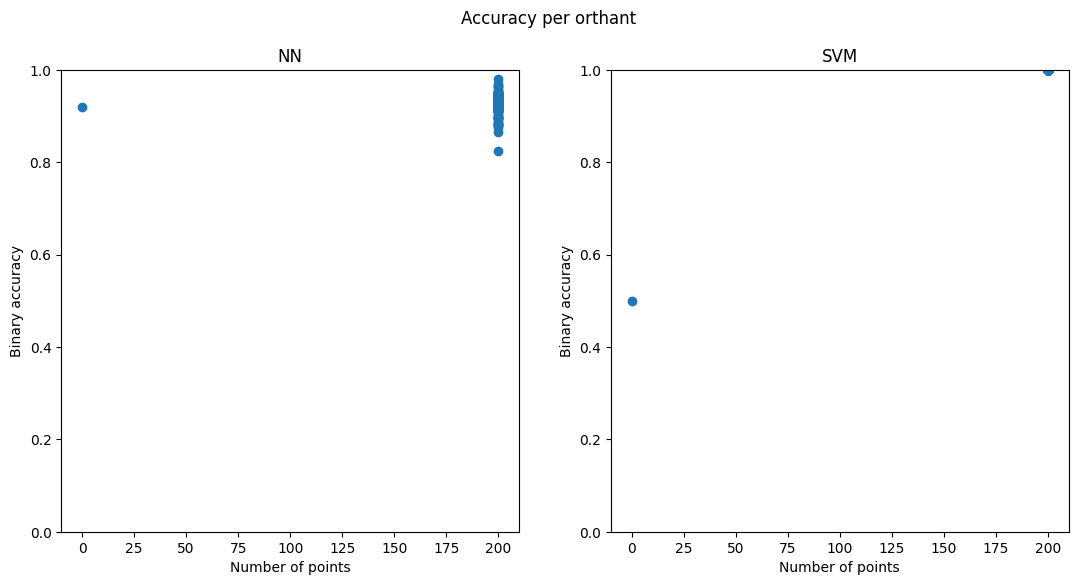

In [39]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('NN')

plt.subplot(122)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('SVM')

plt.suptitle('Accuracy per orthant')